128


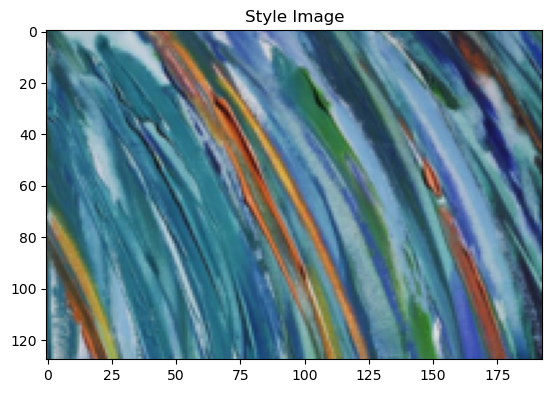

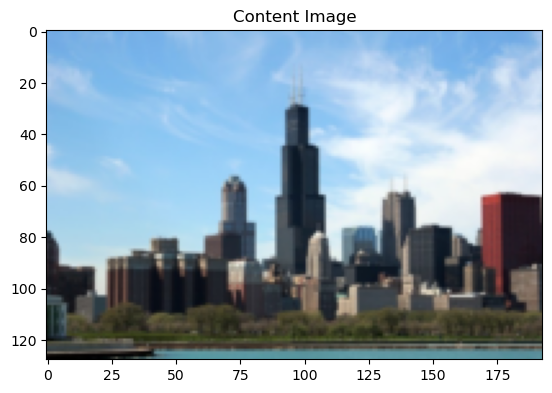

C:\Users\Tanya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


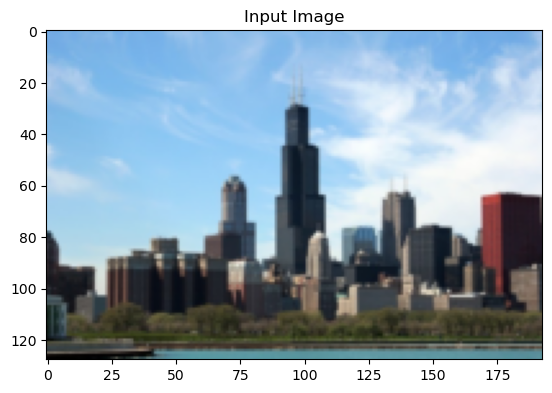

Building the style transfer model...


C:\Users\Tanya\AppData\Local\Temp\ipykernel_6112\3213371780.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\Tanya\AppData\Local\Temp\ipykernel_6112\3213371780.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing...
Iteration 50:
Style Loss: 41.264194 Content Loss: 31.826166

Iteration 100:
Style Loss: 16.463316 Content Loss: 30.417875

Iteration 150:
Style Loss: 8.191429 Content Loss: 28.687689

Iteration 200:
Style Loss: 4.806548 Content Loss: 27.263163

Iteration 250:
Style Loss: 3.432197 Content Loss: 26.217344

Iteration 300:
Style Loss: 2.872198 Content Loss: 25.415154

Iteration 350:
Style Loss: 2.555897 Content Loss: 24.872683

Iteration 400:
Style Loss: 2.340071 Content Loss: 24.538351

Iteration 450:
Style Loss: 2.250355 Content Loss: 24.253538

Iteration 500:
Style Loss: 2.168793 Content Loss: 24.070475

Iteration 550:
Style Loss: 2.131883 Content Loss: 23.920273

Iteration 600:
Style Loss: 2.107519 Content Loss: 23.800364

Iteration 650:
Style Loss: 2.089943 Content Loss: 23.714766

Iteration 700:
Style Loss: 2.080230 Content Loss: 23.644020

Iteration 750:
Style Loss: 2.064267 Content Loss: 23.591436

Iteration 800:
Style Loss: 2.062506 Content Loss: 23.528105



In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 512 if torch.cuda.is_available() else 128  
print(image_size)

image_transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])  

def load_image(image_path):
    image = Image.open(image_path)
    image = image_transform(image).unsqueeze(0)
    return image.to(device, torch.float)

image_dir = "images/"
style_image = load_image(image_dir + "brushstrokes.JPG")
content_image = load_image(image_dir + "chicago.jpg")

assert style_image.size() == content_image.size(), "Style and content images must be of the same size"

to_pil_image = transforms.ToPILImage()  
plt.ion()

def display_image(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = to_pil_image(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
display_image(style_image, title='Style Image')

plt.figure()
display_image(content_image, title='Content Image')

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def calculate_gram_matrix(input):
    batch_size, num_features, height, width = input.size()
    features = input.view(batch_size * num_features, height * width)
    G = torch.mm(features, features.t())
    return G.div(batch_size * num_features * height * width)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = calculate_gram_matrix(target_feature).detach()

    def forward(self, input):
        G = calculate_gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

cnn = models.vgg19(weights=True).features.to(device).eval()
norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def build_model_and_losses(cnn, mean, std, style_img, content_img, content_layers=content_layers, style_layers=style_layers):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(mean, std).to(device)
    content_losses, style_losses = [], []

    model = nn.Sequential(normalization)
    i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break

    model = model[:(j + 1)]
    return model, style_losses, content_losses

input_image = content_image.clone()

plt.figure()
display_image(input_image, title='Input Image')

def configure_optimizer(image):
    optimizer = optim.LBFGS([image.requires_grad_()])
    return optimizer

def execute_style_transfer(cnn, mean, std, content_img, style_img, input_img, steps=300, style_weight=100000, content_weight=1):
    print('Building the style transfer model...')
    model, style_losses, content_losses = build_model_and_losses(cnn, mean, std, style_img, content_img)
    optimizer = configure_optimizer(input_img)

    print('Optimizing...')
    iteration = [0]
    while iteration[0] <= steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_loss_value, content_loss_value = 0, 0

            for sl in style_losses:
                style_loss_value += sl.loss
            for cl in content_losses:
                content_loss_value += cl.loss

            total_style_loss = style_loss_value * style_weight
            total_content_loss = content_loss_value * content_weight
            total_loss = total_style_loss + total_content_loss
            total_loss.backward()

            iteration[0] += 1
            if iteration[0] % 50 == 0:
                print(f"Iteration {iteration[0]}:")
                print(f'Style Loss: {total_style_loss.item():4f} Content Loss: {total_content_loss.item():4f}')
                print()

            return total_style_loss + total_content_loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

output_image = execute_style_transfer(cnn, norm_mean, norm_std, content_image, style_image, input_image, steps=3000)

plt.figure()
display_image(output_image, title='Output Image')
plt.ioff()
plt.show()
